# SCIENTIFIC ARTICLES CLASSIFICATION, A DEEP LEARNING PROJECT

### Libraries import

In [ ]:
import urllib.request
import zipfile
import numpy as np
import pickle as pk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

## Pre Processing - Answers to **Question 2** of the exam

### Data Retrieval and Initialization

This part automates the download and extraction of the dataset from GitHub, preparing features and labels while excluding citation data as specified.

In [ ]:
# ZIP data URL from GitHub
zip_url = "https://github.com/LucaPonzini/Deep-Learning-Project/raw/main/data.zip"

# Download the ZIP
zip_path, _ = urllib.request.urlretrieve(zip_url)

# Unzip the folder
target_folder = "temp"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder)

data_path = f"{target_folder}/data.pkl"

# Open the pickle data
with open(data_path, 'rb') as f:
  data = pk.load(f)

labels = data[2]
feats = data[1]
# edges = data[0] - AS SAID IN THE WRITTEN EXAM I WILL NOT USE THE FIELD CONTAINING THE CITATIONS OF OTHER ARTICLES

### Data visualization

Visualization of the two arrays used and the showing in a histogram the distribution of labels in the dataset.
As we can see two classes have very similar values while the first one is much smaller

In [ ]:
labels # Visualize the "labels" array

array([1, 1, 0, ..., 2, 0, 2])

In [ ]:
feats # Visualize the "feats" array

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.05539719, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.01141881, 0.00467923, ..., 0.        , 0.        ,
        0.        ],
       [0.05307647, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01447173, 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

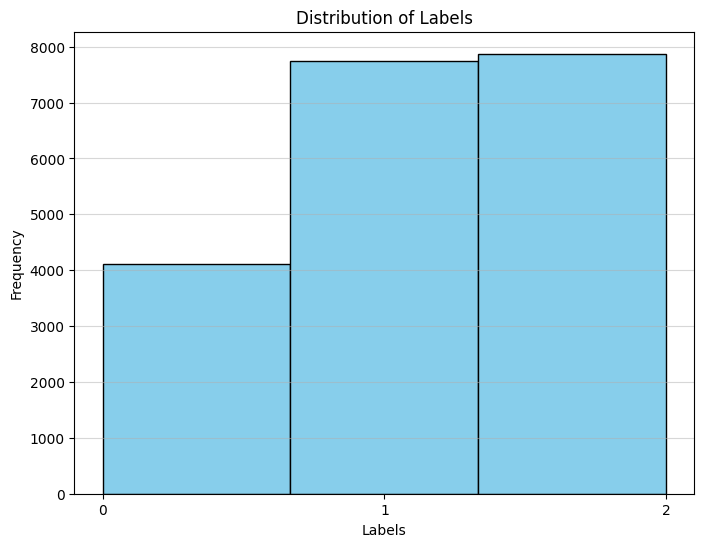

In [ ]:
# Plot histogram of labels
plt.figure(figsize=(8, 6))
plt.hist(labels, bins=len(set(labels)), color='skyblue', edgecolor='black')
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(range(len(set(labels))))
plt.grid(axis='y', alpha=0.5)
plt.show()

### TF-IDF Feature Extraction and Less Useful Word Removal

Here I applied the TF-IDF feature extraction method in order to remove the 50 less useful words for the articles classification, the 50 words were selected among the lowest TF-IDF scores

In [ ]:
# Compute TF-IDF features for the 500 features
tfidf_transformer = TfidfTransformer()
tfidf_feats = tfidf_transformer.fit_transform(feats)

# Compute the mean TF-IDF score for each word across all articles
mean_tfidf_scores = np.asarray(tfidf_feats.mean(axis=0)).flatten()

# Sort the words based on their mean TF-IDF scores
sorted_indices = np.argsort(mean_tfidf_scores)

# Identify the 50 less useful words (lowest TF-IDF scores)
less_useful_words_indices = sorted_indices[:50]

# Remove the 50 less useful words from the TF-IDF features
filtered_tfidf_feats = np.delete(tfidf_feats.toarray(), less_useful_words_indices, axis=1)

# Print the shape of the matrix
print("Shape of the TF-IDF matrix after removing 50 less useful words:", filtered_tfidf_feats.shape)

# Print the TF-IDF matrix
print("TF-IDF matrix after removing 50 less useful words:")
print(filtered_tfidf_feats)

Shape of the TF-IDF matrix after removing 50 less useful words: (19717, 450)
TF-IDF matrix after removing 50 less useful words:
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.25351717 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.0646982  0.01531477 ... 0.         0.         0.        ]
 [0.17034841 0.         0.         ... 0.         0.         0.        ]
 [0.         0.07968803 0.         ... 0.         0.         0.        ]]


### Train-Validation-Test Data Splitting

In this block of code I divided the preprocessed dataset into training, validation, and test subsets to support a structured approach in model training and evaluation.
Initially, it segregates 70% of the data for training and reserves 30% for testing and validation. This reserved portion is further equally split to form distinct validation and test sets. Then, it prints the dimensions of each subset, providing a clear overview of the dataset distribution, which is crucial for understanding the scope of data available for each phase of model development and assessment.

In [ ]:
# Perform train-test split
X_train, X_temp, y_train, y_temp = train_test_split(filtered_tfidf_feats, labels, test_size=0.3, random_state=42)

# Further split the temp set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the sizes of train, validation, and test sets
print("Train set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)

Train set size: (13801, 450)
Validation set size: (2958, 450)
Test set size: (2958, 450)


## Hyperparameters selection and Model configuration - Answer to **Question 5** of the written exam

### Data Reshaping and Encoding for Model Input

These lines of code prepare the dataset for input into the neural network model. They reshape the training and validation feature sets to have an additional dimension, making them compatible with LSTM layers in Keras that expect a 3D array input.
While the last two lines convert integer class labels into one-hot encoded vectors for both the training and validation sets.

In [ ]:
# Reshape and one-hot encode the data appropriately
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_reshaped = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
y_train_encoded = to_categorical(y_train, num_classes=3)
y_val_encoded = to_categorical(y_val, num_classes=3)

### Grid Search for Hyperparameter Configurations

This code defines an expanded grid of hyperparameters for tuning the model. This setup allows for experimentation with different batch sizes and learning rates to optimize model training, while maintaining a consistent number of training cycles and a single level of regularization through dropout.

In [ ]:
# Expanded Hyperparameter Grid
param_grid = {
    'batch_size': [32, 64, 128],
    'epochs': [10],
    'learning_rate': [0.01, 0.001, 0.0001],
    'dropout_rate': [0.2]
}

### Initialization of Best Score and Parameters


Here I initialize `best_score` to track the highest performance metric and `best_params` to store the hyperparameters achieving that score during the tuning process, setting the stage for identifying the optimal model configuration.

In [ ]:
best_score = 0
best_params = {}

### Iterative Hyperparameter Search for Model Training

This code conducts a grid search to fine-tune a neural network model, iterating over predefined hyperparameters. It builds and trains models for each parameter combination, applying early stopping for efficiency. The highest validation accuracy is tracked, updating `best_score` and `best_params` to reflect the optimal configuration found during the search.

In [ ]:
# Grid Search Training
for batch_size in param_grid['batch_size']:
    for epochs in param_grid['epochs']:
        for learning_rate in param_grid['learning_rate']:
            for dropout_rate in param_grid['dropout_rate']:
                print(f"\nTraining with batch_size={batch_size}, epochs={epochs}, learning_rate={learning_rate}, dropout_rate={dropout_rate}")

                # Model definition
                model = Sequential([
                    LSTM(100, kernel_initializer='he_uniform', input_shape=(450, 1)),
                    Dropout(dropout_rate),
                    Dense(3, activation='softmax')
                ])

                optimizer = Adam(learning_rate=learning_rate)
                model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

                # Early stopping
                early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

                # Model fitting
                history = model.fit(X_train_reshaped, y_train_encoded, epochs=epochs, batch_size=batch_size,
                                    validation_data=(X_val_reshaped, y_val_encoded), verbose=1, callbacks=[early_stopping])

                val_accuracy = max(history.history['val_accuracy'])  # Get the best validation accuracy

                if val_accuracy > best_score:
                    best_score = val_accuracy
                    best_params = {
                        'batch_size': batch_size,
                        'epochs': epochs,
                        'learning_rate': learning_rate,
                        'dropout_rate': dropout_rate
                    }


Training with batch_size=32, epochs=10, learning_rate=0.01, dropout_rate=0.2
Epoch 1/10
432/432 [==============================] - 11s 21ms/step - loss: 1.0547 - accuracy: 0.4350 - val_loss: 1.0680 - val_accuracy: 0.3982
Epoch 2/10
432/432 [==============================] - 7s 17ms/step - loss: 1.0184 - accuracy: 0.4298 - val_loss: 0.8487 - val_accuracy: 0.5483
Epoch 3/10
432/432 [==============================] - 8s 18ms/step - loss: 0.8730 - accuracy: 0.5253 - val_loss: 0.8363 - val_accuracy: 0.5382
Epoch 4/10
432/432 [==============================] - 8s 19ms/step - loss: 0.8869 - accuracy: 0.5172 - val_loss: 0.8460 - val_accuracy: 0.5416
Epoch 5/10
432/432 [==============================] - 8s 17ms/step - loss: 0.8548 - accuracy: 0.5496 - val_loss: 0.8208 - val_accuracy: 0.6055
Epoch 6/10
432/432 [==============================] - 8s 19ms/step - loss: 0.8381 - accuracy: 0.5867 - val_loss: 0.7903 - val_accuracy: 0.6349
Epoch 7/10
432/432 [==============================] - 7s 17ms/s

### Final Results printout: Best Validation Accuracy and Corresponding Hyperparameters

Here it outputs the highest validation accuracy achieved during the grid search and the set of hyperparameters that led to this performance. It marks the conclusion of the hyperparameter tuning process, providing a clear summary of the optimal model configuration for reference or further analysis.

In [ ]:
# Final Printout
print("\nBest Validation Accuracy:", best_score)
print("Best Hyperparameters:", best_params)


Best Validation Accuracy: 0.6494252681732178
Best Hyperparameters: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.01, 'dropout_rate': 0.2}


## Model Construction with Optimized Hyperparameters

In this section there are the answers to **Question 1** (model=LSTM), **Question 3** (output=dense softmax layer), **Question 4** (loss function=categorical cross entropy)

### Setting LSTM Units for Potential Optimization

In [ ]:
# Optimizing LSTM units based on prior knowledge/experimentation
lstm_units = 150  # Adjusted to 150 units for potential optimization

### Model Architecture Definition

### Model with Optimized Hyperparameters

This code constructs and compiles an LSTM model using the best hyperparameters identified from the grid search, including the optimal dropout rate and learning rate. It sets up the model with a specific LSTM unit count, dropout for regularization, a softmax output layer for classification, and compiles it with the Adam optimizer to enhance performance based on the tuning results.

In [ ]:
# Model with the dynamically set best hyperparameters
final_model = Sequential([
    LSTM(lstm_units, kernel_initializer='he_uniform', input_shape=(450, 1)),
    Dropout(best_params['dropout_rate']),  # Dynamically use the best dropout rate found
    Dense(3, activation='softmax')
])

optimizer = Adam(learning_rate=best_params['learning_rate'])  # Dynamically use the best learning rate found
final_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

### Training Configuration

Here I set training to 50 epochs and used early stopping based on validation loss to prevent overfitting, automatically restoring the model to its best state.

In [ ]:
epochs = 50 # Increased epochs to get a more optimal solution
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

### Training the Final Model

Here the final model is trained with all the best pararmeters found in the above steps

In [ ]:
history = final_model.fit(X_train_reshaped, y_train_encoded, epochs=epochs,
                          batch_size=best_params['batch_size'],
                          validation_data=(X_val_reshaped, y_val_encoded),
                          verbose=1, callbacks=[early_stopping])

Epoch 1/50
432/432 [==============================] - 10s 20ms/step - loss: 1.0738 - accuracy: 0.4281 - val_loss: 1.0030 - val_accuracy: 0.4571
Epoch 2/50
432/432 [==============================] - 8s 19ms/step - loss: 0.9819 - accuracy: 0.4618 - val_loss: 0.9890 - val_accuracy: 0.4672
Epoch 3/50
432/432 [==============================] - 7s 17ms/step - loss: 0.9801 - accuracy: 0.4727 - val_loss: 0.9879 - val_accuracy: 0.4530
Epoch 4/50
432/432 [==============================] - 8s 19ms/step - loss: 0.9828 - accuracy: 0.4637 - val_loss: 1.0060 - val_accuracy: 0.4594
Epoch 5/50
432/432 [==============================] - 8s 19ms/step - loss: 0.9746 - accuracy: 0.5095 - val_loss: 0.9735 - val_accuracy: 0.5446
Epoch 6/50
432/432 [==============================] - 8s 17ms/step - loss: 0.9955 - accuracy: 0.5082 - val_loss: 1.0317 - val_accuracy: 0.4926
Epoch 7/50
432/432 [==============================] - 9s 21ms/step - loss: 1.0183 - accuracy: 0.4988 - val_loss: 1.0045 - val_accuracy: 0.511

### Final Training Report

In [ ]:
print(f"Best Validation Accuracy achieved: {max(history.history['val_accuracy'])}")

Best Validation Accuracy achieved: 0.7139959335327148


## Model Evaluation and Performance Analysis - answer to **Question 6** of the written exam

### Training and Validation Accuracy over Epochs

Here is a graph in which we can see the trend of the validation accuracy over the epochs

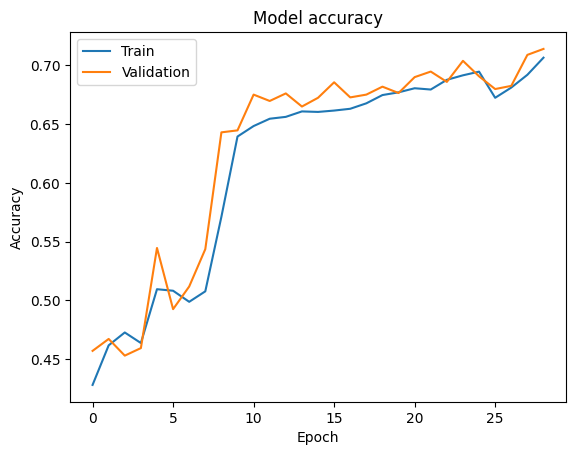

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Training and Validation Loss over Epochs

Here is a graph in which we can see the trend of the validation loss over the epochs

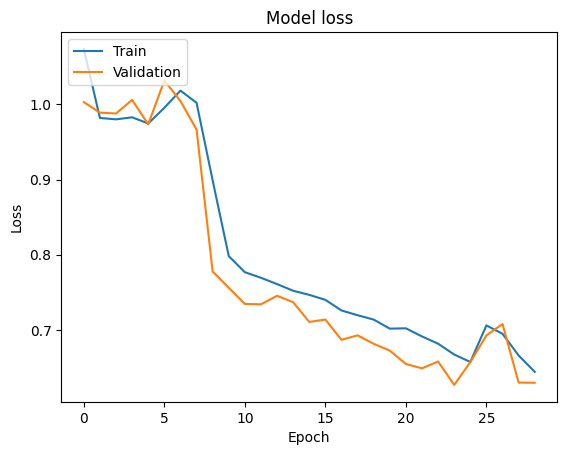

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Generating Model Predictions for Validation Data


This code generates predictions using the trained Keras model (final_model) on the validation dataset (X_val_reshaped).

In [ ]:
# Generate predictions
predictions = final_model.predict(X_val_reshaped)
predicted_classes = np.argmax(predictions, axis=1)

93/93 [==============================] - 1s 9ms/step


### Confusion Matrix Analysis

This code computes and plots the confusion matrix based on the true class labels (true_classes) and the predicted class labels (predicted_classes).
True Positives (TP): The diagonal elements represent the number of correctly predicted samples for each class.
False Positives (FP): Off-diagonal elements in a row indicate the number of samples that were incorrectly predicted as belonging to that class.
False Negatives (FN): Off-diagonal elements in a column represent the number of samples that actually belong to that class but were incorrectly predicted as belonging to another class.
True Negatives (TN): Elements outside the current class row and column indicate the number of correctly predicted samples that do not belong to that class.

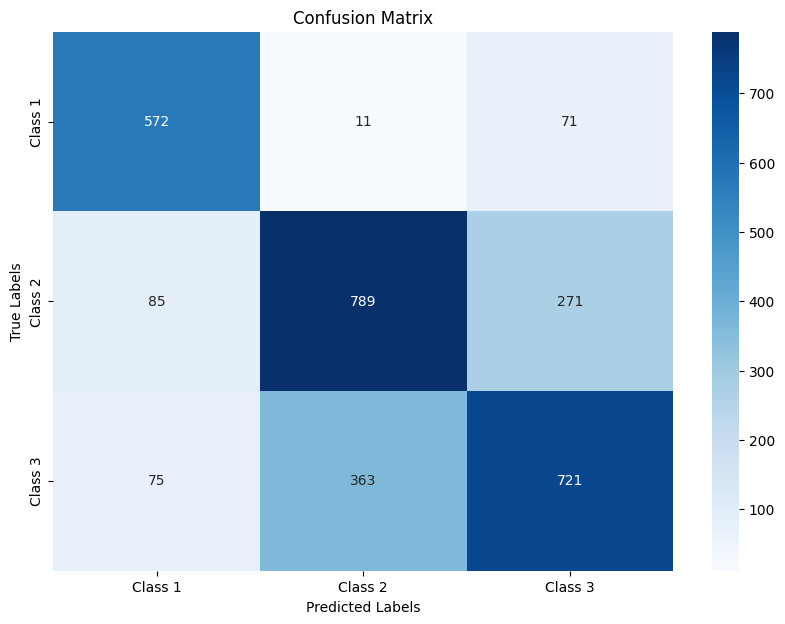

In [ ]:
# Convert one-hot encoded y_val_encoded back to class labels
true_classes = np.argmax(y_val_encoded, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 1", "Class 2", "Class 3"], yticklabels=["Class 1", "Class 2", "Class 3"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Computing F1 Score for Model Evaluation

This code calculates the F1 score, a measure of a model's accuracy, based on the predicted class labels (predicted_classes) and the true class labels (true_classes).
I used the F1 score in addition to accuracy because it provides a more comprehensive evaluation of the model's performance.

In [ ]:
# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# true_classes are the true labels encoded as integers
f1 = f1_score(true_classes, predicted_classes, average='weighted')  # 'weighted' accounts for label imbalance
print(f"F1 Score: {f1}")

F1 Score: 0.7014220619647173
